# percobaan 1 

## grayscale, ekualisasi histogram, sharpening

In [216]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
import random

In [217]:
dataset = "dataset"
folders = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]

num_files = np.array([len(os.listdir(os.path.join(dataset, folder))) for folder in folders])

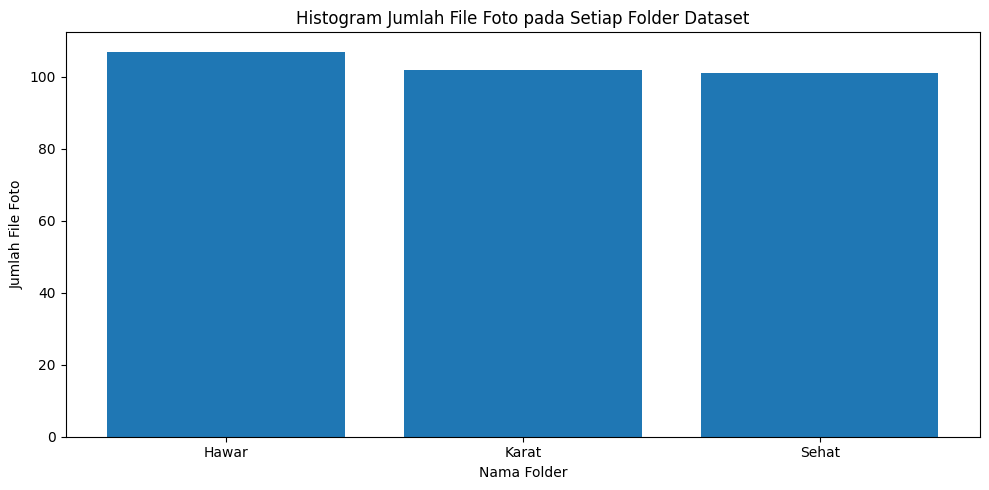

In [218]:
plt.figure(figsize=(10, 5))
plt.bar(folders, num_files)
plt.xlabel('Nama Folder')
plt.ylabel('Jumlah File Foto')
plt.title('Histogram Jumlah File Foto pada Setiap Folder Dataset')
plt.tight_layout()
plt.show()

In [219]:
def resize(img, new_width=256, new_height=256):
    old_width, old_height = img.shape
    resize = np.zeros((new_width, new_height), dtype=img.dtype)

    for i in range(new_width):
        for j in range(new_height):
            x = int(i * old_width / new_width)
            y = int(j * old_height / new_height)
            resize[i,j] = img[x,y] 
    return resize

data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        img = resize(img)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

In [220]:
def imageByLabel(dataset):
    folders = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]
    
    fig, axs = plt.subplots(1, len(folders), figsize=(15, 5))
    for i, folder in enumerate(folders):
        folder_path = os.path.join(dataset, folder)
        image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg') or file.endswith('.png')]
        
        if len(image_files) > 0:
            random_image = random.choice(image_files)
            img_path = os.path.join(folder_path, random_image)
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            
            axs[i].imshow(img)
            axs[i].set_title(f"Label: {folder}")
            axs[i].axis('off')

    plt.show()

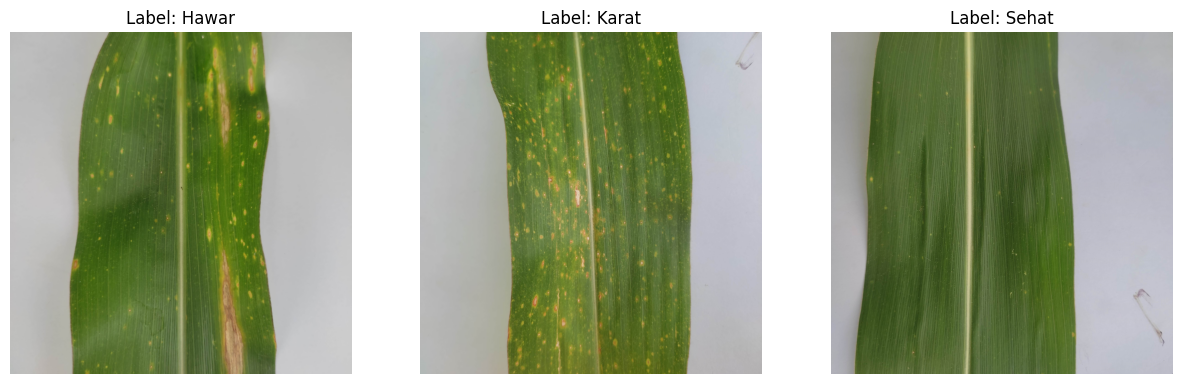

In [221]:
imageByLabel(dataset)

In [222]:
def show_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

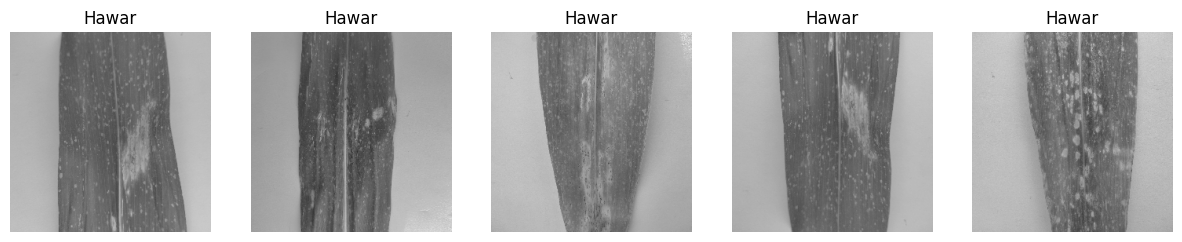

In [223]:
show_images(data[:5], labels[:5])

In [224]:
def displayRes(images, title):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(title + f' {i+1}')
    plt.show()

# Data Preparation

### Ekualisasi histogram

In [225]:
# 2. Hitung histogram citra asli
def get_histogram(img):
    hist = np.zeros(256, dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1
    return hist

In [226]:
# 3. Hitung distribusi kumulatif (CDF)
def dist_kumulatif(hist):
    cdf = np.zeros(256, dtype=float)
    total_pixels = np.sum(hist)
    cumulative = 0
    for i in range(256):
        cumulative += hist[i]
        cdf[i] = cumulative / total_pixels
    return cdf

In [227]:
# 4. Normalisasi CDF ke rentang 0-255
def normalisasi_cdf(cdf):
    cdf_normalized = np.round(cdf * 255).astype(np.uint8)
    return cdf_normalized

In [228]:
# 5. Mapping nilai piksel berdasarkan CDF
def mapping_nilai(img, mapping):
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i, j] = mapping[img[i, j]]
    return result

In [229]:
# Proses Ekualisasi Histogram
hist = get_histogram(data)
cdf = dist_kumulatif(hist)
mapping = normalisasi_cdf(cdf)
    
# hasilek = rounding(timeline)
hasil_ekualisasi = mapping_nilai(data, mapping)
# ekualisasi_img2 = mapping_nilai(gabungan_mc, mapping)

hist_ekualisasi = get_histogram(hasil_ekualisasi)

### Sharpening

In [230]:
kernel5x5 = np.array([
    [1/25,1/25,1/25,1/25,1/25,],
    [1/25,1/25,1/25,1/25,1/25,],
    [1/25,1/25,1/25,1/25,1/25,],
    [1/25,1/25,1/25,1/25,1/25,],
    [1/25,1/25,1/25,1/25,1/25,],
])

In [231]:

def padding5x5(image):
    return np.pad(image, pad_width=2, mode='edge')

In [232]:
def sharpening(image, kernel):
    height, width = image.shape
    kh, kw = kernel.shape
    result = np.zeros((height, width), dtype=int)
    padded_image = padding5x5(image)
    
    for i in range(height):
        for j in range(width):
            region = padded_image[i:i+kh, j:j+kw]
            result[i, j] = np.sum(region * kernel)
    
    return result

### Treshold

In [233]:
def use_threshold(image):
    image = np.array(image)
    result = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] >= 127 :
                result[i][j] = 255
            else:
                result[i][j] = 0
    return result

### Closing

In [234]:
def dilasi(img, kernel):
    result = np.zeros_like(img, dtype=float)
    m, n = img.shape
    k1, k2 = kernel.shape
    center1, center2 = k1 // 2, k2 // 2

    for i in range(center1, m - center1):
        for j in range(center2, n - center2):
            for k in range(-center1, center1 + 1):
                for l in range(-center2, center2 + 1):
                    if kernel[k + center1, l + center2] == 1:
                        if img[i + k, j + l] == 255:
                            result[i, j] = 255
                            break
                if result[i, j] == 255:
                    break

    return result

In [235]:
def padding(image):
    return np.pad(image, pad_width=2, mode='edge')

# Erosi
def erosi(image, kernel):
    baris, kolom = image.shape
    result = np.zeros_like(image)
    img_pad = padding(image)
    
    for i in range(baris):
        for j in range(kolom):
            if img_pad[i + 2, j + 2] == 255:
                cocok = True
                for k in range(kernel.shape[0]):
                    for l in range(kernel.shape[1]):
                        if kernel[k, l] == 1 and img_pad[i + k, j + l] == 0:
                            cocok = False
                if cocok:
                    result[i, j] = 255
                else:
                    result[i, j] = 0
    return result

In [236]:
def closing(citra, kernel):
    hasil = np.zeros(citra.shape, dtype=int)

    citra_dilasi = dilasi(citra, kernel)
    hasil = erosi(citra_dilasi, kernel)
    
    return hasil

## Define Preprocessing Function


In [ ]:
#grayscale, ekualisasi histogram, sharpening,

def prepro1(data):

    #1 ekualisasi histogram
    img_eq = mapping_nilai(img, mapping)
    
    #2 sharpening
    img_sharp = sharpening(img_eq, kernel5x5)

    #3 konversi
    img_final = img_sharp.astype(np.uint8)


    return img_final

## Proprocessing

In [238]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
	img = data[i]
	
	# coba pakai salah satu prepro, misal prepro1
	data_prepro1 = prepro1(img) 

	dataPreprocessed.append(data_prepro1)

## Feature Extraction

In [239]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [240]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [241]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [242]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [243]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [244]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [245]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [246]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [247]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [248]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [249]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [250]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [251]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [252]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [253]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [254]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [255]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

## Write the extraction's results to CSV 

In [256]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,001.jpg,Hawar,41.915870,45.294287,6.286443,49.574994,0.407143,0.384906,0.571061,0.374184,...,0.002516,0.001450,0.041342,0.039080,0.050155,0.038074,0.994916,0.994508,0.999239,0.993989
1,002.jpg,Hawar,62.272595,71.651519,7.074923,65.330488,0.484321,0.435138,0.586321,0.448971,...,0.003113,0.002250,0.051410,0.046351,0.055792,0.047437,0.994181,0.993307,0.999339,0.993898
2,003.jpg,Hawar,23.930438,25.640092,4.001900,29.027359,0.455424,0.413268,0.572598,0.419618,...,0.002312,0.001611,0.044343,0.040146,0.048081,0.040143,0.995305,0.994973,0.999215,0.994309
3,004.jpg,Hawar,40.877911,44.798247,5.967096,47.412534,0.424514,0.395034,0.579034,0.395802,...,0.002687,0.001679,0.043766,0.040308,0.051839,0.040973,0.995141,0.994676,0.999292,0.994366
4,005.jpg,Hawar,38.931434,46.859946,11.673468,52.126398,0.384472,0.348256,0.491154,0.335853,...,0.002241,0.001556,0.044599,0.039767,0.047335,0.039447,0.994782,0.993718,0.998435,0.993012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,097.jpg,Sehat,65.654136,69.891042,3.231464,66.672234,0.463498,0.438620,0.641056,0.436306,...,0.002878,0.001924,0.046924,0.044083,0.053645,0.043859,0.995310,0.995010,0.999769,0.995240
306,098.jpg,Sehat,72.220941,75.793464,1.735463,71.631050,0.460646,0.433975,0.698838,0.434050,...,0.002603,0.001639,0.043159,0.040707,0.051020,0.040488,0.994108,0.993817,0.999859,0.994157
307,099.jpg,Sehat,62.985539,60.666990,4.008134,71.794710,0.476815,0.451805,0.633588,0.447931,...,0.002952,0.002077,0.048665,0.045587,0.054337,0.045573,0.995437,0.995607,0.999710,0.994801
308,100.jpg,Sehat,65.150015,72.375902,2.248790,61.400554,0.465357,0.449446,0.682199,0.454353,...,0.004768,0.003426,0.060991,0.058850,0.069054,0.058532,0.995480,0.994979,0.999844,0.995741


## Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

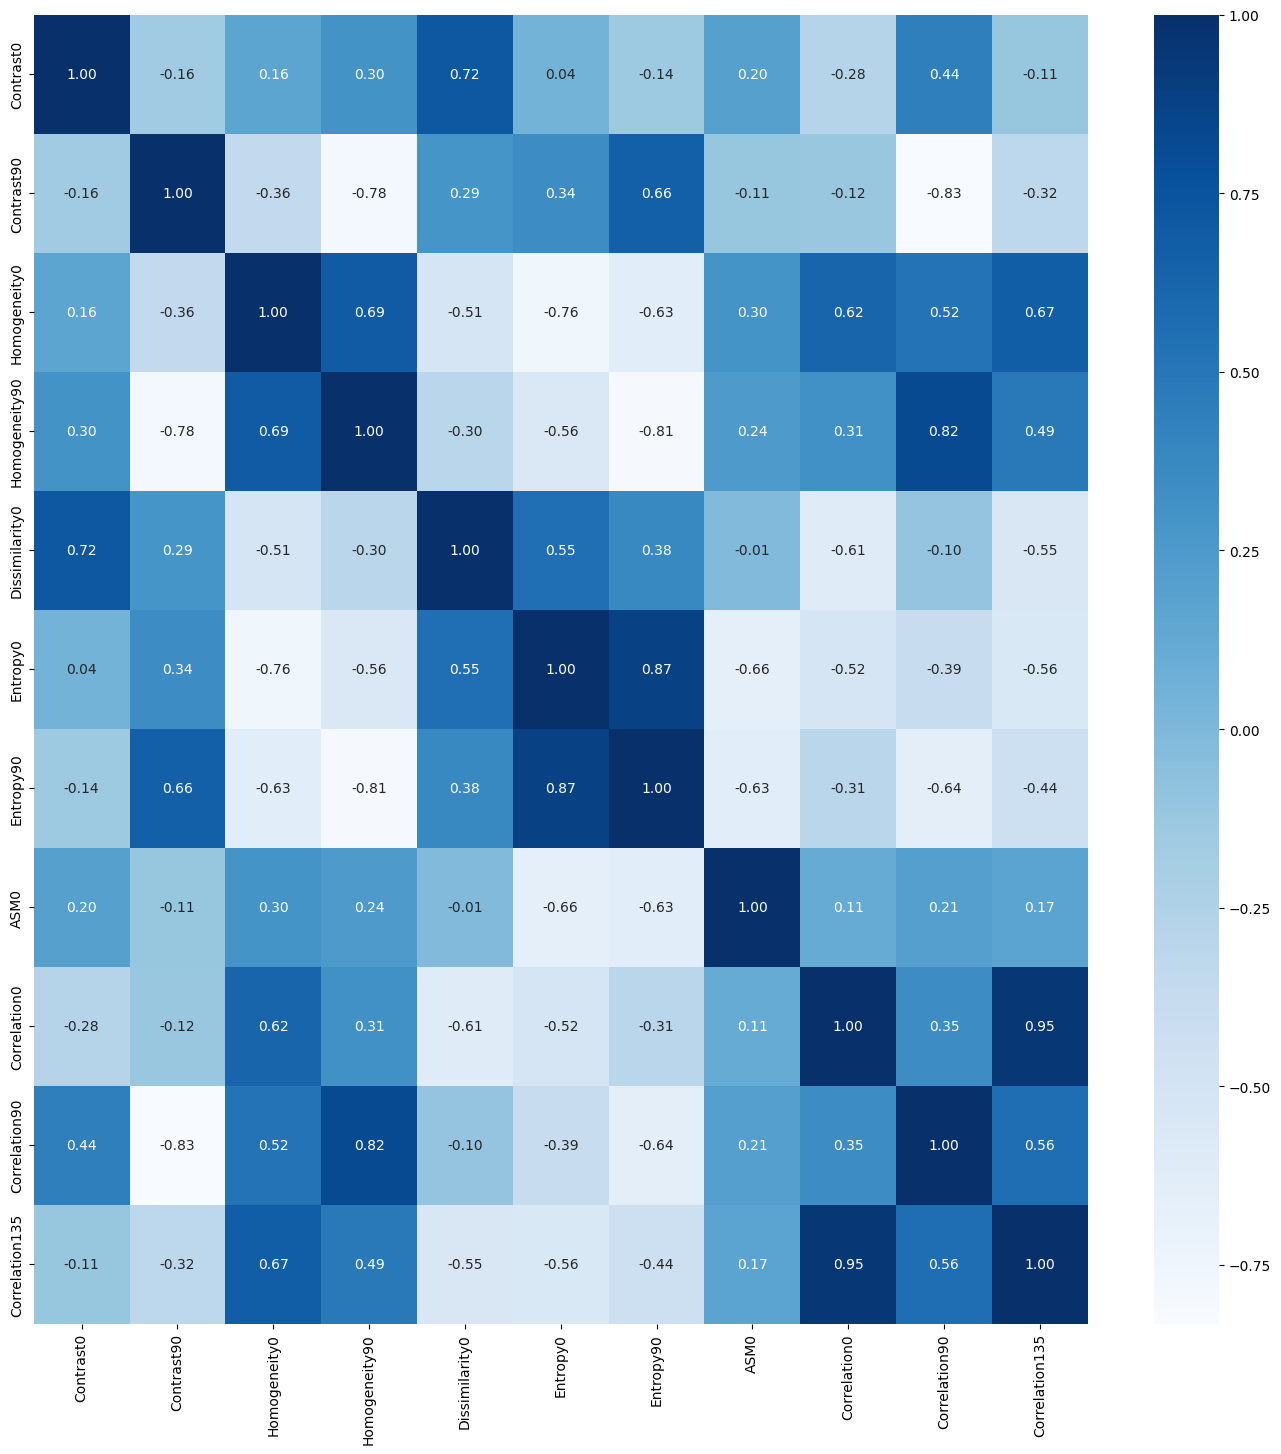

In [257]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [258]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(248, 11)
(62, 11)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [259]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [260]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [261]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       Hawar       0.97      0.93      0.95        83
       Karat       0.94      0.98      0.96        82
       Sehat       0.99      1.00      0.99        83

    accuracy                           0.97       248
   macro avg       0.97      0.97      0.97       248
weighted avg       0.97      0.97      0.97       248

[[77  5  1]
 [ 2 80  0]
 [ 0  0 83]]
Accuracy: 0.967741935483871

------Testing Set------
              precision    recall  f1-score   support

       Hawar       0.90      0.75      0.82        24
       Karat       0.77      0.85      0.81        20
       Sehat       0.90      1.00      0.95        18

    accuracy                           0.85        62
   macro avg       0.86      0.87      0.86        62
weighted avg       0.86      0.85      0.85        62

[[18  5  1]
 [ 2 17  1]
 [ 0  0 18]]
Accuracy: 0.8548387096774194


### Train SVM Classifier

In [262]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       Hawar       0.87      0.73      0.80        83
       Karat       0.81      0.90      0.86        82
       Sehat       0.93      0.98      0.95        83

    accuracy                           0.87       248
   macro avg       0.87      0.87      0.87       248
weighted avg       0.87      0.87      0.87       248

[[61 17  5]
 [ 7 74  1]
 [ 2  0 81]]
Accuracy: 0.8709677419354839

------Testing Set------
              precision    recall  f1-score   support

       Hawar       0.94      0.71      0.81        24
       Karat       0.73      0.80      0.76        20
       Sehat       0.82      1.00      0.90        18

    accuracy                           0.82        62
   macro avg       0.83      0.84      0.82        62
weighted avg       0.84      0.82      0.82        62

[[17  6  1]
 [ 1 16  3]
 [ 0  0 18]]
Accuracy: 0.8225806451612904


### Train KNN Classifier

In [263]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       Hawar       0.81      0.81      0.81        83
       Karat       0.85      0.82      0.83        82
       Sehat       0.92      0.95      0.93        83

    accuracy                           0.86       248
   macro avg       0.86      0.86      0.86       248
weighted avg       0.86      0.86      0.86       248

[[67 12  4]
 [12 67  3]
 [ 4  0 79]]
Accuracy: 0.8588709677419355

------Testing Set------
              precision    recall  f1-score   support

       Hawar       0.75      0.75      0.75        24
       Karat       0.72      0.65      0.68        20
       Sehat       0.90      1.00      0.95        18

    accuracy                           0.79        62
   macro avg       0.79      0.80      0.79        62
weighted avg       0.78      0.79      0.79        62

[[18  5  1]
 [ 6 13  1]
 [ 0  0 18]]
Accuracy: 0.7903225806451613


## Evaluation With Confusion Matrix

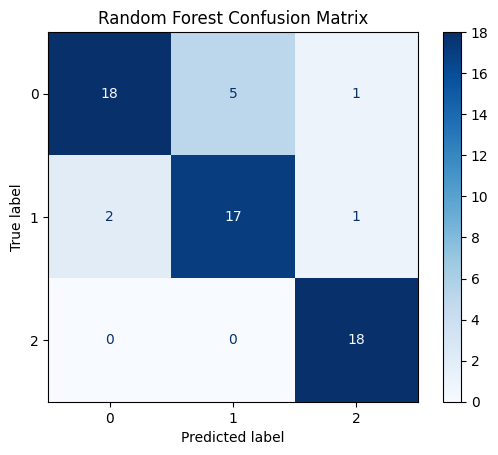

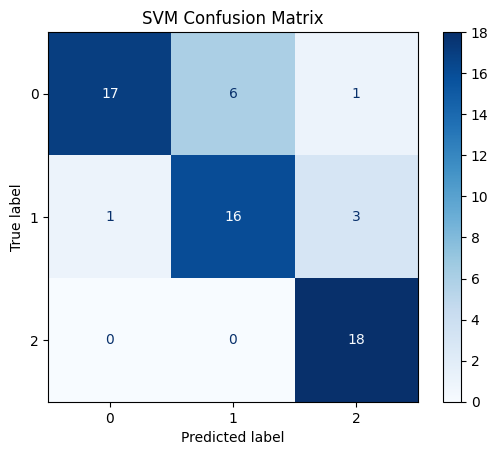

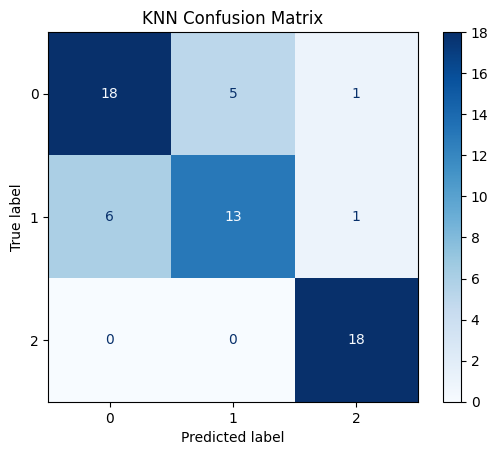

In [264]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")